In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('dummy.csv')
df.head()

,GMB,Diameter,Param1,Param2,Possible
0,2,138,0.127,47,1
1,0,84,0.233,23,0
2,0,145,0.630,31,1
3,0,135,0.365,24,1
4,1,139,0.536,21,0


In [3]:
#lets describe the data
df.describe()

,GMB,Diameter,Param1,Param2,Possible
count,531.000000,531.000000,531.000000,531.000000,531.000000
mean,3.743879,119.830508,0.480209,33.018832,0.335217
std,3.314112,33.124942,0.331977,11.860018,0.472511
min,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,98.500000,0.253000,24.000000,0.000000
50%,3.000000,116.000000,0.380000,29.000000,0.000000
75%,6.000000,140.500000,0.646000,40.000000,1.000000
max,17.000000,197.000000,2.420000,81.000000,1.000000


In [4]:
#infromation of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 5 columns):
GMB         531 non-null int64
Diameter    531 non-null int64
Param1      531 non-null float64
Param2      531 non-null int64
Possible    531 non-null int64
dtypes: float64(1), int64(4)
memory usage: 20.8 KB


In [5]:
#any null values 
#not neccessary in above information we can see
df.isnull().values.any()

False

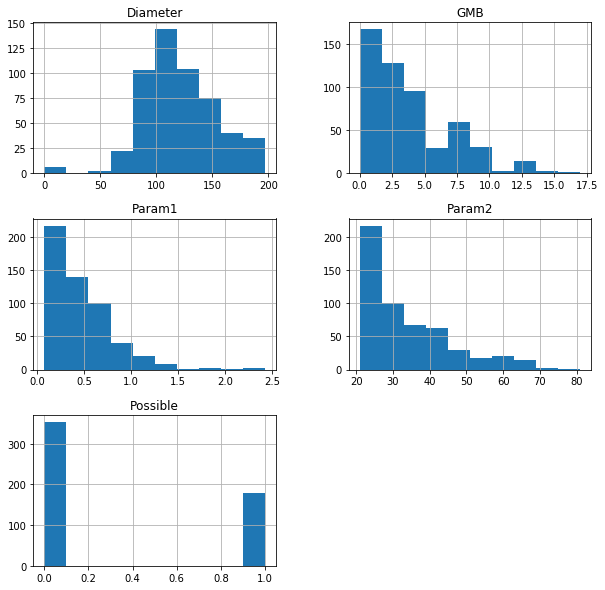

In [6]:
#histogram
df.hist(bins=10,figsize=(10,10))
plt.show()

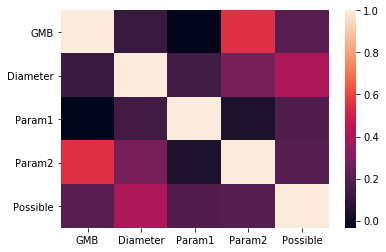

In [7]:
#correlation

sns.heatmap(df.corr())
# we can see skin thickness,insulin,pregnencies and age are full independent to each other
#age and pregencies has negative correlation

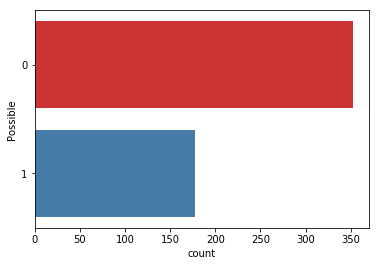

In [8]:
#lets count total outcome in each target 0 1
#0 means no diabeted
#1 means patient with diabtes
sns.countplot(y=df['Possible'],palette='Set1')

In [9]:
#outlier remove

Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1

print("---Q1--- \n",Q1)
print("\n---Q3--- \n",Q3)
print("\n---IQR---\n",IQR)

#print((df < (Q1 - 1.5 * IQR))|(df > (Q3 + 1.5 * IQR)))


---Q1--- 
 GMB          1.000
Diameter    98.500
Param1       0.253
Param2      24.000
Possible     0.000
Name: 0.25, dtype: float64

---Q3--- 
 GMB           6.000
Diameter    140.500
Param1        0.646
Param2       40.000
Possible      1.000
Name: 0.75, dtype: float64

---IQR---
 GMB          5.000
Diameter    42.000
Param1       0.393
Param2      16.000
Possible     1.000
dtype: float64


In [10]:
#outlier remove
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape,df_out.shape
#more than 80 records deleted|

((531, 5), (494, 5))

LinAlgError: singular matrix

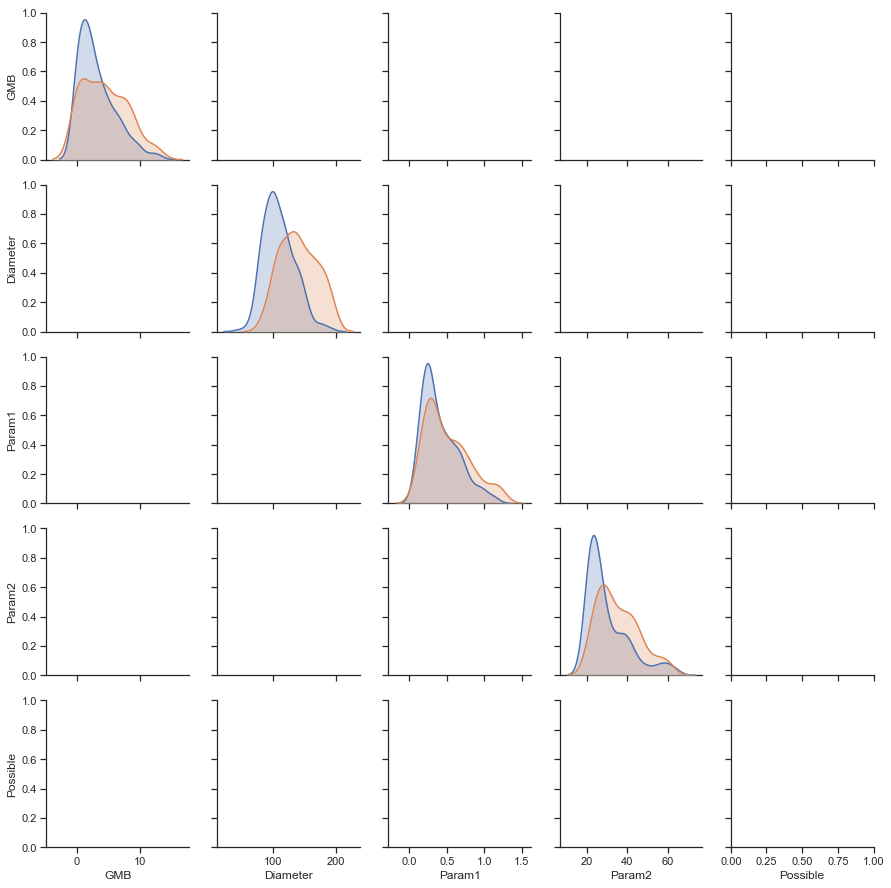

In [11]:
#Scatter matrix after removing outlier
sns.set(style="ticks")
sns.pairplot(df_out, hue="Possible")
plt.show()

In [15]:
#lets extract features and targets
X=df_out.drop(columns=['Possible'])
y=df_out['Possible']

In [16]:
#Splitting train test data 80 20 ratio
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2)

train_X.shape,test_X.shape,train_y.shape,test_y.shape

((395, 4), (99, 4), (395,), (99,))

Note
sensitivity = true positives / ( true positives + false positives )

specificity = true negatives / ( true negatives + false positives )

Type I error = 1 - specificity

Type II error = 1 - sensitivity

Positive Likelihood Ratio = sensitivity / (1 - specificity)

Negative Likelihood Ratio = (1 - sensitivity) / specificity

gain = sensitivity / ( (true positives + true negatives) / n )

auc = (tpr - fpr + 1) / 2

F-Score = 2 * (precision * recall) / (precision + recall)

Hanssen-Kuiper skill score (aka true score statistic) = [(tp * tn) - (fp * fn)] / [(tp + fn) + (fp + tn)], The true skill score has an expected -1 to +1, with 0 representing no discrimination.

Using the table function matrix positions for a 2x2 confusion matrix are TP(1), FN(3), FP(2), TN(4)

In [17]:
from sklearn.metrics import confusion_matrix,accuracy_score,make_scorer
from sklearn.model_selection import cross_validate

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

#cross validation purpose
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision'}
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

def display_result(result):
    print("TP: ",result['test_tp'])
    print("TN: ",result['test_tn'])
    print("FN: ",result['test_fn'])
    print("FP: ",result['test_fp'])

In [18]:
from sklearn.metrics import roc_auc_score

acc=[]
roc=[]

In [23]:
#KNN

from sklearn.neighbors import KNeighborsClassifier

clf=KNeighborsClassifier(n_neighbors=3)
clf.fit(train_X,train_y)
y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()


Accuracy 0.5858585858585859 ROC 0.5243303571428571
TP:  [ 8  8 10  4  5 11  7  6  7  4]
TN:  [26 20 25 24 21 22 25 23 19 21]
FN:  [5 5 3 9 8 2 5 6 5 8]
FP:  [1 7 2 3 6 5 2 4 8 5]



Accuracy 0.6565656565656566 ROC 0.5984375


c:\users\asus\pygo\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TP:  [ 8  6 11  2  5 11  8  6 11  4]
TN:  [26 25 25 26 24 26 24 26 24 22]
FN:  [ 5  7  2 11  8  2  4  6  1  8]
FP:  [1 2 2 1 3 1 3 1 3 4]


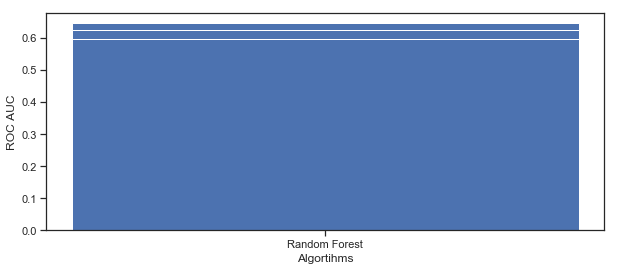

In [24]:
#Random forest
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier()
clf.fit(train_X,train_y)

y_pred=clf.predict(test_X)
#find accuracy
ac=accuracy_score(test_y,y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(test_y,y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
display_result(result)

ax=plt.figure(figsize=(10,4))
plt.bar(['Random Forest'],roc,label='ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Algortihms')
plt.show()

#display predicted values uncomment below line
#pd.DataFrame(data={'Actual':test_y,'Predicted':y_pred}).head()